In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1947_bacteria_4876.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1946_bacteria_4875.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1952_bacteria_4883.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1954_bacteria_4886.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1951_bacteria_4882.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1946_bacteria_4874.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1949_bacteria_4880.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/per

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import cv2
from keras import Sequential
from keras.layers import Flatten,Dense,BatchNormalization,Dropout,LeakyReLU,GlobalAveragePooling2D
from keras.optimizers import Adam,RMSprop
from keras.losses import BinaryCrossentropy
from keras.applications import ResNet50V2
from keras.callbacks import EarlyStopping




In [ ]:
train_path = "/kaggle/input/chest-xray-pneumonia/chest_xray/train/"
val_path = "/kaggle/input/chest-xray-pneumonia/chest_xray/val/"
test_path = "/kaggle/input/chest-xray-pneumonia/chest_xray/test/"

In [ ]:
normal = glob.glob(train_path+"NORMAL/*.jpeg")
pneumonia = glob.glob(train_path+"PNEUMONIA/*.jpeg")

In [ ]:
number_of_normal_img = len(normal)
number_of_pneumonia_img = len(pneumonia)
print("number of normal images:", number_of_normal_img)
print("number of pneumonia images:", number_of_pneumonia_img)

number of normal images: 1341
number of pneumonia images: 3875


In [ ]:
train_val_generator = ImageDataGenerator(rescale=1./255,horizontal_flip=True,zoom_range=0.3)
test_generator = ImageDataGenerator(rescale=1./255)

In [ ]:
train = train_val_generator.flow_from_directory(train_path,
                                               batch_size=128,
                                               target_size=(220,220),
                                               color_mode="rgb",
                                               class_mode="binary",
                                               shuffle=True,
                                               seed=42,
                                               subset="training")

Found 5216 images belonging to 2 classes.


In [ ]:
val = train_val_generator.flow_from_directory(val_path,
                                               batch_size=4,
                                               target_size=(220,220),
                                               color_mode="rgb",
                                               class_mode="binary",
                                               shuffle=True,
                                               seed=42)

Found 16 images belonging to 2 classes.


In [ ]:
test = test_generator.flow_from_directory(test_path,
                                          batch_size=32,
                                          target_size=(220,220),
                                          color_mode="rgb",
                                          class_mode="binary")

Found 624 images belonging to 2 classes.


In [ ]:
resnet50 = ResNet50V2(weights = "imagenet", input_shape = (220,220,3), include_top = False)

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
for layer in resnet50.layers:
    layer.trainable = False

In [ ]:
model = Sequential()

model.add(resnet50)

for layer in resnet50.layers:
    layer.trainable = False

model.add(Flatten())

model.add(Dense(units = 128, activation = "relu"))
model.add(Dropout(0.5))

model.add(Dense(units = 1, activation = "sigmoid"))

In [ ]:
model.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)              │ (None, 7, 7, 2048)          │      23,564,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      12,845,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 36,410,113 (138.89 MB)

 Trainable params: 12,845,313 (49.00 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

In [ ]:
hist = model.fit(train,validation_data=val,epochs=5)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


41/41 ━━━━━━━━━━━━━━━━━━━━ 559s 13s/step - accuracy: 0.7895 - loss: 3.6661 - val_accuracy: 0.7500 - val_loss: 0.8335
Epoch 2/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 555s 13s/step - accuracy: 0.9219 - loss: 0.1998 - val_accuracy: 0.7500 - val_loss: 0.5058
Epoch 3/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 545s 13s/step - accuracy: 0.9316 - loss: 0.1619 - val_accuracy: 0.8750 - val_loss: 0.7738
Epoch 4/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 542s 13s/step - accuracy: 0.9452 - loss: 0.1447 - val_accuracy: 0.7500 - val_loss: 0.8268
Epoch 5/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 544s 13s/step - accuracy: 0.9512 - loss: 0.1229 - val_accuracy: 0.7500 - val_loss: 0.8786


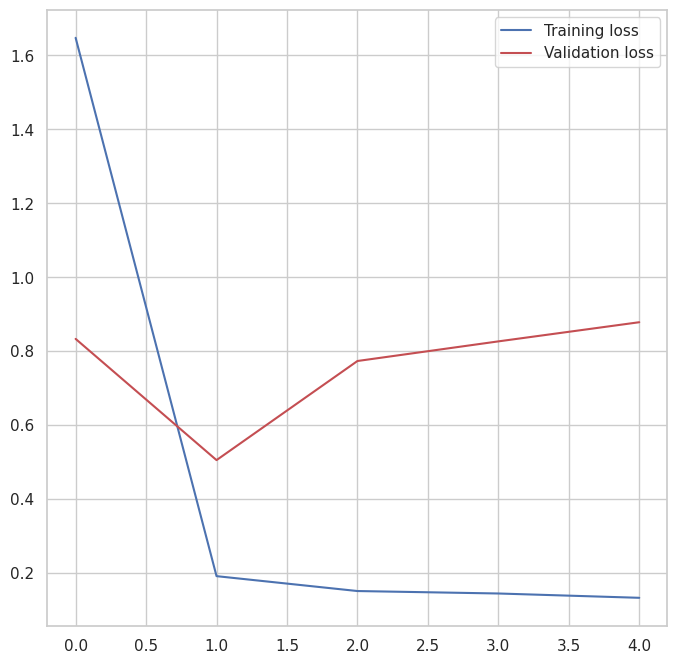

<Figure size 640x480 with 0 Axes>

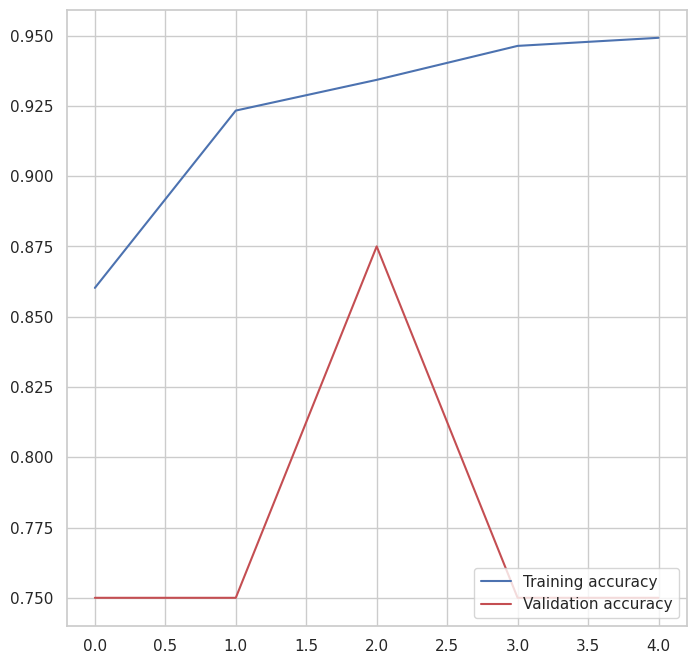

In [ ]:
plt.figure(figsize=(8,8))
plt.plot(hist.history['loss'], color='b', label="Training loss")
plt.plot(hist.history['val_loss'], color='r', label="Validation loss")
plt.legend()
plt.show()

plt.figure()

plt.figure(figsize=(8,8))
plt.plot(hist.history['accuracy'], color='b', label="Training accuracy")
plt.plot(hist.history['val_accuracy'], color='r',label="Validation accuracy")
plt.legend(loc = "lower right")
plt.show()

In [ ]:
test_results = model.evaluate(test)

20/20 ━━━━━━━━━━━━━━━━━━━━ 55s 3s/step - accuracy: 0.9380 - loss: 0.2407
